In [367]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## LOAD AND PREPARE DATA

In [368]:
df = pd.read_csv("../data/atp_tennis.csv")

In [369]:
df['Date'] = pd.to_datetime(df['Date'])

In [370]:
df['Year'] = df['Date'].dt.year

In [371]:
# Filter data with odds available (from 2001 onwards)
df_with_odds = df[(df['Odd_1'] != -1) & (df['Year'] >= 2001)].copy()
print(f"Total matches: {len(df)}")
print(f"Matches with odds (2001+): {len(df_with_odds)}")

Total matches: 66613
Matches with odds (2001+): 62831


## 1. UPSETS ANALYSIS

In [372]:
df_with_odds['Upset'] = ((df_with_odds['Odd_1'] > df_with_odds['Odd_2']) & 
                         (df_with_odds['Winner'] == df_with_odds['Player_1']))

In [373]:
upset_rate_by_year = (df_with_odds.groupby('Year')['Upset'].mean() * 100)

In [374]:
# Calculate upset rate by year
print(f"\nOverall upset rate: {df_with_odds['Upset'].mean()*100:.2f}%")
print(f"Year with most upsets: {upset_rate_by_year.idxmax()} ({upset_rate_by_year.max():.2f}%)")
print(f"Year with fewest upsets: {upset_rate_by_year.idxmin()} ({upset_rate_by_year.min():.2f}%)")


Overall upset rate: 14.48%
Year with most upsets: 2023 (15.89%)
Year with fewest upsets: 2007 (12.83%)


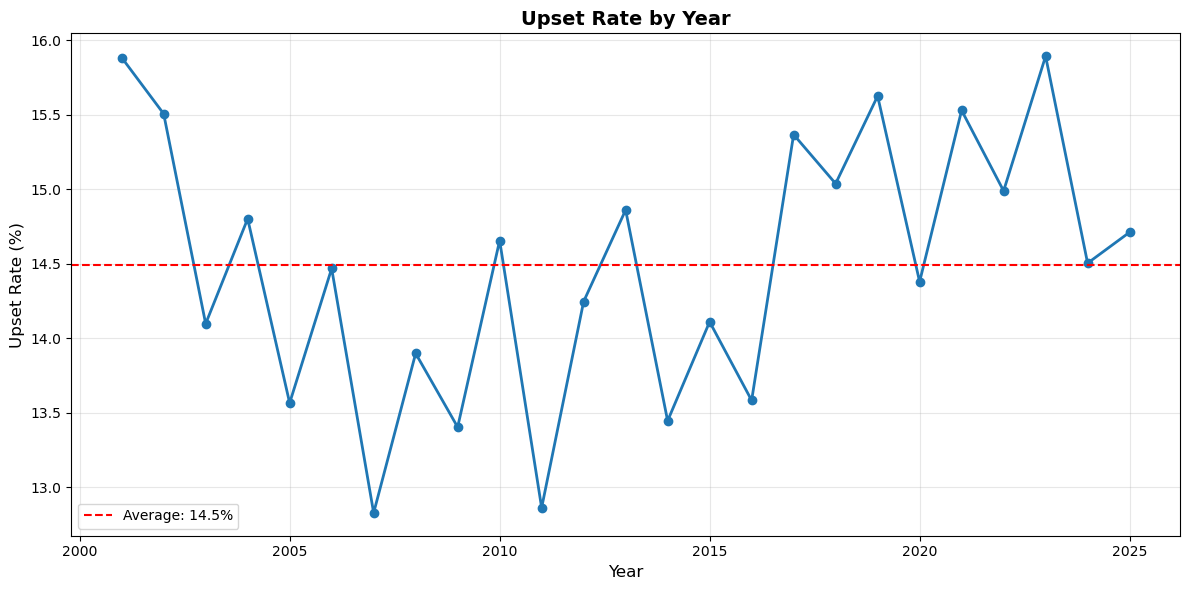

In [375]:
# Plot upset rate over time
plt.figure(figsize=(12,6))
plt.plot(upset_rate_by_year.index, upset_rate_by_year.values, marker='o', linewidth=2, markersize=6)
plt.axhline(y=upset_rate_by_year.mean(), color='red', linestyle='--', 
            label=f'Average: {upset_rate_by_year.mean():.1f}%')
plt.title('Upset Rate by Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Upset Rate (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

- Average upset rate is around 14-15% per year, showing consistency in odds predictability
- Some peaks (2017, 2019, 2021) indicate seasons with higher competitive instability
- No clear long-term trend; men's tennis has remained relatively predictable over two decades
- The element of surprise persists in about 1 in every 7 matches

## 2. ERA DOMINANCE ANALYSIS

In [376]:
bins = [1999, 2009, 2019, 2025]
labels = ['2000-2010', '2010-2020', '2020-2025']
df['Era'] = pd.cut(df['Year'], bins=bins, labels=labels)

In [377]:
# Count wins by era and player
wins_by_era = df.groupby(['Era', 'Winner'], observed=False).size().reset_index(name='Wins')

In [378]:
top5_per_era = (
    wins_by_era
    .sort_values(['Era', 'Wins'], ascending=[True, False],)
    .groupby('Era', observed=False)
    .head(5)
    .reset_index(drop=True)
)

In [379]:
# Separate by era
era_2000 = top5_per_era[top5_per_era['Era'] == '2000-2010']
era_2010 = top5_per_era[top5_per_era['Era'] == '2010-2020']
era_2020 = top5_per_era[top5_per_era['Era'] == '2020-2025']

##### Top 5 Winners per Era: 

In [380]:
print("\n2000-2010:")
print(era_2000.to_string(index=False))



2000-2010:
      Era       Winner  Wins
2000-2010   Federer R.   612
2000-2010   Roddick A.   465
2000-2010    Hewitt L.   415
2000-2010 Ferrero J.C.   370
2000-2010     Nadal R.   367


In [381]:
print("\n2010-2020:")
print(era_2010.to_string(index=False))



2010-2020:
      Era      Winner  Wins
2010-2020 Djokovic N.   588
2010-2020    Nadal R.   543
2010-2020  Federer R.   526
2010-2020   Ferrer D.   411
2010-2020   Murray A.   410


In [382]:
print("\n2020-2025:")
print(era_2020.to_string(index=False))


2020-2025:
      Era      Winner  Wins
2020-2025   Sinner J.   285
2020-2025   Zverev A.   263
2020-2025   Rublev A.   262
2020-2025 Medvedev D.   258
2020-2025  Alcaraz C.   250


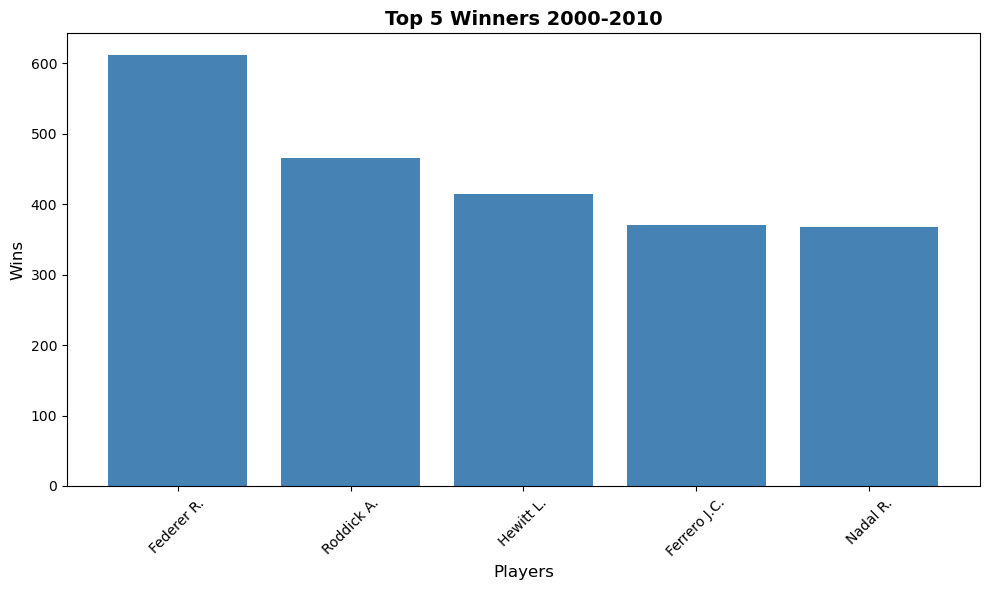

In [383]:
# Era 2000-2010
plt.figure(figsize=(10, 6))
plt.bar(era_2000['Winner'], era_2000['Wins'], color='steelblue')
plt.title('Top 5 Winners 2000-2010', fontsize=14, fontweight='bold')
plt.xlabel('Players', fontsize=12)
plt.ylabel('Wins', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


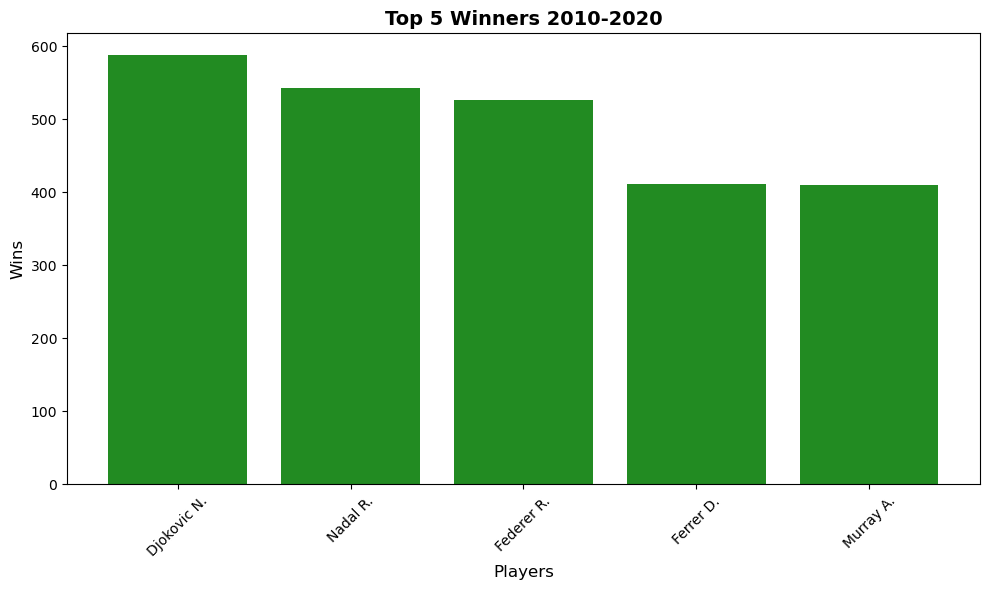

In [384]:
# Era 2010-2020
plt.figure(figsize=(10, 6))
plt.bar(era_2010['Winner'], era_2010['Wins'], color='forestgreen')
plt.title('Top 5 Winners 2010-2020', fontsize=14, fontweight='bold')
plt.xlabel('Players', fontsize=12)
plt.ylabel('Wins', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

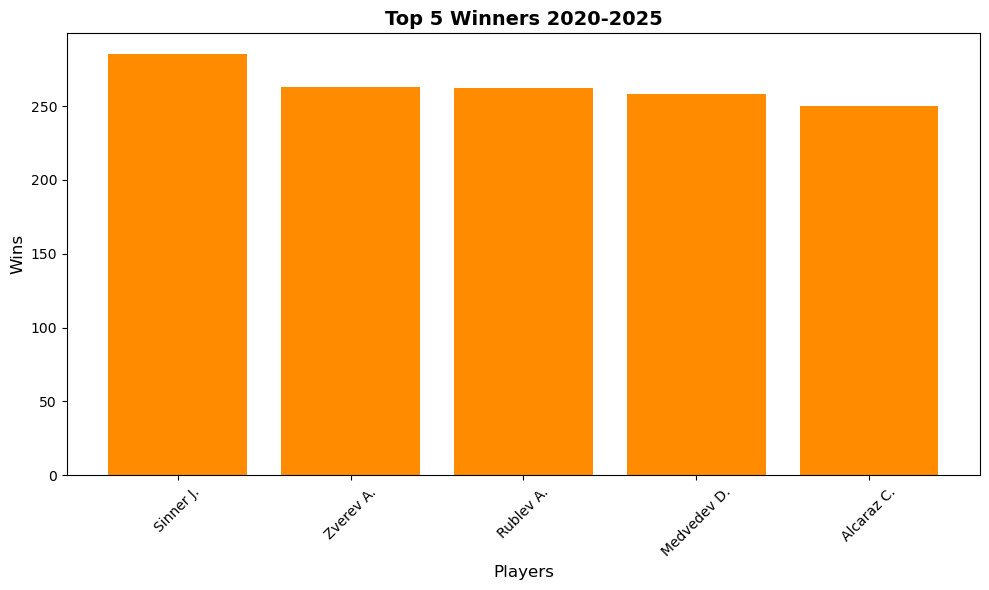

In [385]:
# Era 2020-2025
plt.figure(figsize=(10, 6))
plt.bar(era_2020['Winner'], era_2020['Wins'], color='darkorange')
plt.title('Top 5 Winners 2020-2025', fontsize=14, fontweight='bold')
plt.xlabel('Players', fontsize=12)
plt.ylabel('Wins', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## RANKING CORRELATION WITH RESULTS

In [386]:
# Calculate ranking difference
df["Rank_diff"] = df['Rank_1'] - df['Rank_2']

In [387]:
# Identify better ranked player
df['Better_ranked'] = df.apply(lambda x: x['Player_1'] if x['Rank_diff'] < 0 
                               else (x['Player_2'] if x['Rank_diff'] > 0 else 'Tie'), axis=1
)

In [388]:
# Categorize ranking differences
bins = [0, 10, 30, 60, float('inf')]
labels = ['Balanced', 'Slight advantage', 'Moderate advantage', 'Large difference']
df['Rank_category'] = pd.cut(df['Rank_diff'].abs(), bins=bins, labels=labels, include_lowest=True)

In [389]:
# Calculate win rate of better ranked player
df['Better_ranked_won'] = df['Winner'] == df['Better_ranked']
win_rate_by_rank_diff = df.groupby('Rank_category', observed=False)['Better_ranked_won'].mean() * 100


In [390]:
print("\nWin Rate of Better Ranked Player by Ranking Difference:")
print(win_rate_by_rank_diff)


Win Rate of Better Ranked Player by Ranking Difference:
Rank_category
Balanced              55.045292
Slight advantage      60.426949
Moderate advantage    65.640876
Large difference      72.817880
Name: Better_ranked_won, dtype: float64


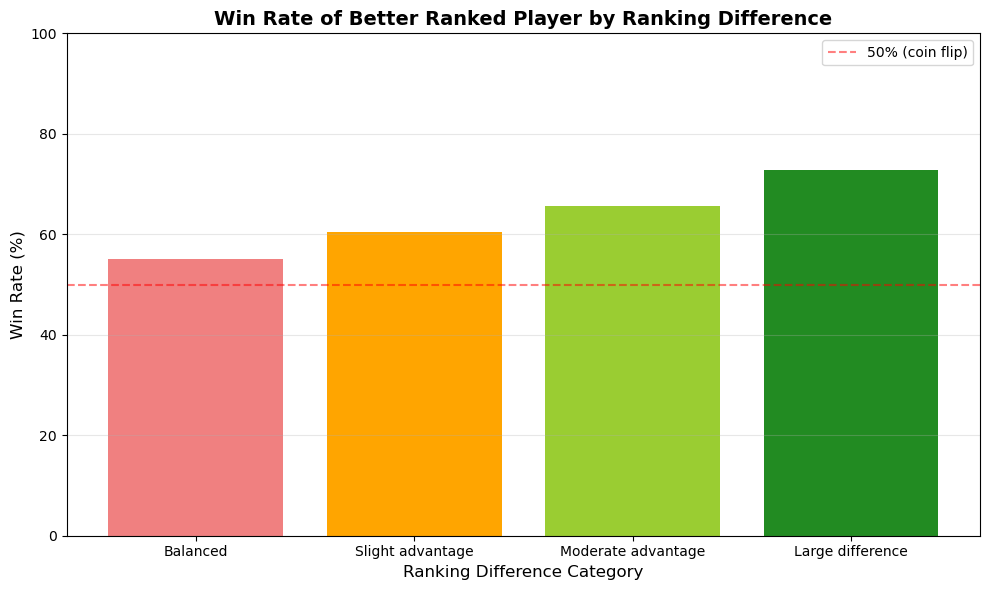

In [391]:
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(win_rate_by_rank_diff)), win_rate_by_rank_diff.values, 
               color=['lightcoral', 'orange', 'yellowgreen', 'forestgreen'])
plt.xticks(range(len(win_rate_by_rank_diff)), win_rate_by_rank_diff.index, rotation=0)
plt.title('Win Rate of Better Ranked Player by Ranking Difference', 
          fontsize=14, fontweight='bold')
plt.ylabel('Win Rate (%)', fontsize=12)
plt.xlabel('Ranking Difference Category', fontsize=12)
plt.ylim(0, 100)
plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (coin flip)')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

- Positive correlation between ranking difference and win rate
- The larger the ranking gap, the higher the probability of the better-ranked player winning
- In balanced matches (difference up to 10 positions), outcomes tend to be unpredictable


##  ROI ANALYSIS - BETTING ON FAVORITES

In [392]:
# Define favorite by odds (lower odd = favorite)
df_with_odds['Favorite'] = df_with_odds.apply(lambda x: x['Player_1'] if x['Odd_1'] < x['Odd_2'] 
                                              else x['Player_2'], axis=1)

In [393]:
# Check if bet was correct
df_with_odds['Bet_won'] = df_with_odds['Winner'] == df_with_odds['Favorite']

In [394]:
# Calculate profit (simplified: +1 for win, -1 for loss)
df_with_odds['Profit'] = df_with_odds['Bet_won'].apply(lambda x: 1 if x else -1)

In [395]:
# Calculate ROI
total_profit = df_with_odds['Profit'].sum()
total_bets = len(df_with_odds)
roi = (total_profit / total_bets) * 100
win_rate = df_with_odds['Bet_won'].mean() * 100

In [396]:
print(f"\nBetting Strategy: Always bet on the favorite (by odds)")
print(f"Total bets: {total_bets}")
print(f"Winning bets: {df_with_odds['Bet_won'].sum()}")
print(f"Win rate: {win_rate:.2f}%")
print(f"Total profit: {total_profit} units (assuming 1 unit per bet)")
print(f"ROI: {roi:.2f}%")


Betting Strategy: Always bet on the favorite (by odds)
Total bets: 62831
Winning bets: 43779
Win rate: 69.68%
Total profit: 24727 units (assuming 1 unit per bet)
ROI: 39.35%


In [397]:
# ROI by year
roi_by_year = df_with_odds.groupby('Year').apply(
    lambda x: (x['Profit'].sum() / len(x)) * 100, include_groups=False
)

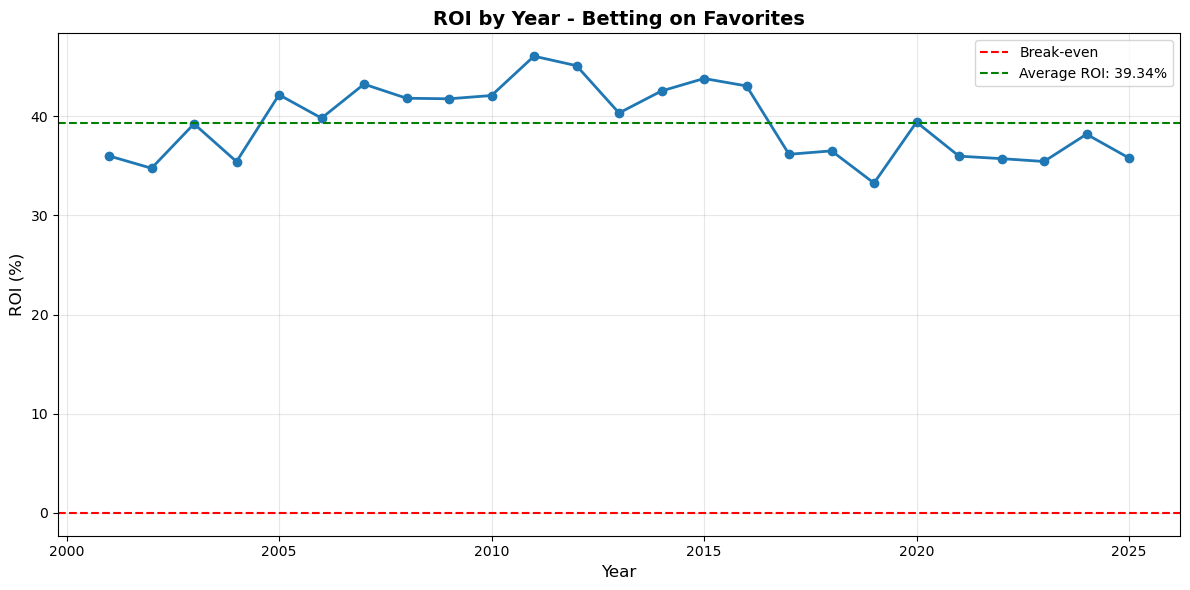

In [398]:
plt.figure(figsize=(12, 6))
plt.plot(roi_by_year.index, roi_by_year.values, marker='o', linewidth=2, markersize=6)
plt.axhline(y=0, color='red', linestyle='--', label='Break-even')
plt.axhline(y=roi_by_year.mean(), color='green', linestyle='--', 
            label=f'Average ROI: {roi_by_year.mean():.2f}%')
plt.title('ROI by Year - Betting on Favorites', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('ROI (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

While betting on favorites has a high success rate, the low odds offered by bookmakers mean this strategy would likely **break even or lose money** in real-world betting scenarios. The tennis betting market is efficient, and odds are set to ensure bookmaker profitability regardless of which player wins.